In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = '/home/datasets/Project_data'

We set the random seed so that the results don't vary drastically.

In [4]:
train_doc = np.random.permutation(open(data_dir + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_dir + '/val.csv').readlines())
batch_size = 40 #experiment with the batch size

np.random.seed(30) import random as rn rn.seed(30) from tensorflow import keras import tensorflow as tf tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

data path: /home/datasets/Project_data

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines()) 

val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines()) batch_size = 40

#### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [5]:
x = 30 # No. of frames images
#y = 120 # Width of the image
#z = 120 # height

# parameterize the width and height to test with different sizes
def generator(source_path, folder_list, batch_size, width=120, height=120):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = resize(image,(width, height)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(width, height)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = data_dir + '/train'
val_path = data_dir + '/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [7]:
# Import all the necessary libraries to train model
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
#from keras import optimizers #Code provided by upgrad does not work
from keras import optimizers

In [8]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Note change the parameter to False, else disk would run out of space.

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#### Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
class model_architecture:
    # initialize default parameter
    num_epochs = 25
    batch_size = 40
    image_width_height = 120
    
    #defining constructor  
    def __init__(self, num_epochs = 15, batch_size = 40, image_width_height = 120):  
        self.num_epochs = num_epochs  
        self.batch_size = batch_size 
        self.image_width_height = image_width_height
        
    def define_conv3d_architecture_1(self):
        model_arch_1 = Sequential()       
        model_arch_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(Activation('relu'))

        model_arch_1.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

        # Flatten layer 
        model_arch_1.add(Flatten())
        model_arch_1.add(Dense(1000, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        model_arch_1.add(Dense(500, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        #Softmax layer
        model_arch_1.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        model_arch_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_1.summary())

        self.model_arch = model_arch_1
        
    # SGD optimizer with decay, momentum and nesterov    
    def define_conv3d_architecture_1_sgd_variant(self):
        model_arch_1 = Sequential()       
        model_arch_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(Activation('relu'))

        model_arch_1.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

        # Flatten layer 
        model_arch_1.add(Flatten())
        model_arch_1.add(Dense(1000, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        model_arch_1.add(Dense(500, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        #Softmax layer
        model_arch_1.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #write your optimizer
        model_arch_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_1.summary())

        self.model_arch = model_arch_1    

    
    # different variant of architecture 1, with dropouts at more dense layer   
    def define_conv3d_architecture_2(self):
        model_arch_2 = Sequential()       
        model_arch_2.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(Activation('relu'))

        model_arch_2.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_2.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        model_arch_2.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        model_arch_2.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        # Flatten layer 
        model_arch_2.add(Flatten())
        model_arch_2.add(Dense(1000, activation='relu'))
        model_arch_2.add(Dropout(0.5))

        model_arch_2.add(Dense(500, activation='relu'))
        model_arch_2.add(Dropout(0.5))

        #Softmax layer
        model_arch_2.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        model_arch_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_2.summary())

        self.model_arch = model_arch_2
    
    #architecture with different layer and drop-out at dense layer with 0.5 & 0.25
    def define_conv3d_architecture_3(self):
        model_arch_3 = Sequential()       
        model_arch_3.add(Conv3D(16,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3), activation='relu', padding='same'))
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_3.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_3.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model_arch_3.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_3.add(Dropout(0.25))

        # Flatten layer 
        model_arch_3.add(Flatten())
        model_arch_3.add(Dense(1000, activation='relu'))
        model_arch_3.add(Dropout(0.5))

        model_arch_3.add(Dense(500, activation='relu'))
        model_arch_3.add(Dropout(0.25))

        #Softmax layer
        model_arch_3.add(Dense(5, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        
        model_arch_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_3.summary())

        self.model_arch = model_arch_3

    # Define LSTM architecture
    def define_rnn_lstm_architecture_1(self):
        model_rnn_lstm = Sequential()   
        model_rnn_lstm.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'), input_shape=(30, self.image_width_height, self.image_width_height, 3)))
        model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
        model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
        model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
        model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model_rnn_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
        model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
        model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
        model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Flatten layer 
        model_rnn_lstm.add(TimeDistributed(Flatten()))
        model_rnn_lstm.add(LSTM(256))
        model_rnn_lstm.add(Dropout(0.25))

        # Dense layer 
        model_rnn_lstm.add(Dense(128,activation='relu'))
        model_rnn_lstm.add(Dropout(0.25))

        # Softmax layer
        model_rnn_lstm.add(Dense(5, activation='softmax'))

        # Adam optimiser
        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        model_rnn_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_rnn_lstm.summary())
        
        self.model_arch = model_rnn_lstm
    
    
    #Define gru architecture, to be compared with LSTM
    def define_rnn_gru_architecture_1(self):
        model_rnn_gru = Sequential()   
        model_rnn_gru.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'), input_shape=(30, self.image_width_height, self.image_width_height, 3)))
        model_rnn_gru.add(TimeDistributed(BatchNormalization()))
        model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_gru.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
        model_rnn_gru.add(TimeDistributed(BatchNormalization()))
        model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model_rnn_gru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model_rnn_gru.add(TimeDistributed(BatchNormalization()))
        model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_gru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model_rnn_gru.add(TimeDistributed(BatchNormalization()))
        model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

        model_rnn_gru.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model_rnn_gru.add(TimeDistributed(BatchNormalization()))
        model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Flatten layer 
        model_rnn_gru.add(TimeDistributed(Flatten()))
        model_rnn_gru.add(GRU(256))
        model_rnn_gru.add(Dropout(0.25))

        # Dense layer 
        model_rnn_gru.add(Dense(128,activation='relu'))
        model_rnn_gru.add(Dropout(0.25))

        # Softmax layer
        model_rnn_gru.add(Dense(5, activation='softmax'))

        # Adam optimiser
        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        model_rnn_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_rnn_gru.summary())
        
        self.model_arch = model_rnn_gru
    
    
    def cal_validation_steps_per_epoch(self):
        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1

        return steps_per_epoch, validation_steps

    def plot(self, history):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].grid()
        axes[0].legend(['loss','val_loss'])
        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].grid()
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    def execute(self):
        # Now that you have defined the model in define_conv3d_architecture_1, the next step is to `compile` the model. 
        # When you print the `summary` of the model, you'll see the total number of parameters you have to train.
        train_generator = generator(train_path, train_doc, self.batch_size, self.image_width_height, self.image_width_height)
        val_generator = generator(val_path, val_doc, self.batch_size, self.image_width_height, self.image_width_height)

        #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
        steps_per_epoch, validation_steps = self.cal_validation_steps_per_epoch()

        history = self.model_arch.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose=1, 
                        callbacks = callbacks_list, validation_data = val_generator, 
                        validation_steps = validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.plot(history)
        
        return history

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

# Define model architecture with num_epoch, batch_size, input image size
model_1 = model_architecture(15, 40, 120)
model_1.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_1.execute()

2023-02-11 09:06:25.495447: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-11 09:06:25.495511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

2023-02-11 09:06:35.426813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 5.3652 - categorical_accuracy: 0.3725Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 3.63263, saving model to model_init_2023-02-1109_06_19.913282/model-00001-5.36519-0.37255-3.63263-0.12000.h5
17/17 [==============================] - 159s 9s/step - loss: 5.3652 - categorical_accuracy: 0.3725 - val_loss: 3.6326 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.9683 - categorical_accuracy: 0.5524
Epoch 00002: val_loss did not improve from 3.63263
17/17 [==============================] - 92s 6s/step - loss: 1.9683 - categorical_accuracy: 0.5524 - val_loss: 5.5319 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.2604 - categorical_accuracy: 0.6656
Epoch 00004: val_loss did not improve from 3.63263
17/17 [==============================] - 

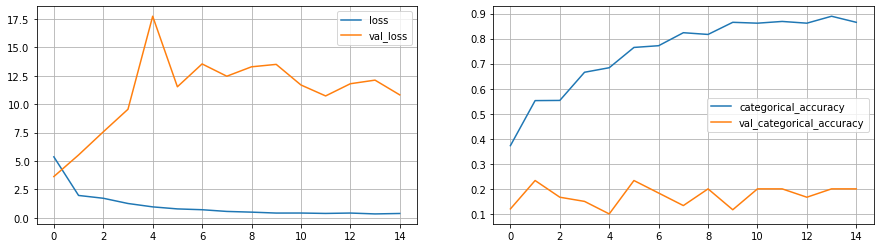

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_1 = model_architecture(15, 40, 120)
model_1.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_1.execute()

Model 1:
Training accuracy: 86.51 Validation accuracy: 20.00 Validation loss: 0.3809

In initial run we see model overfits with less number of epochs. Validation loss did not improve and fairly averaged around 10. With less number of epochs (15) validation loss ends with 8.3430. Running the model with more number of epochs should be tried.

#### Model-2 input summary (Conv3d architecture) : Hyperparameter tuning (With more number of epochs)
input image size(120x120) epochs: 25 batch size: 40

Expected output: Compared to previous architecture, training/validation accuracy should improve and validation loss should go down

2023-02-05 10:25:17.857852: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-05 10:25:17.857920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

2023-02-05 10:25:27.903989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 7.2833 - categorical_accuracy: 0.3137Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 2.31603, saving model to model_init_2023-02-0510_22_55.933122/model-00001-7.28334-0.31373-2.31603-0.20000.h5
17/17 [==============================] - 164s 10s/step - loss: 7.2833 - categorical_accuracy: 0.3137 - val_loss: 2.3160 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 0.4587 - categorical_accuracy: 0.8166
Epoch 00008: val_loss did not improve from 1.63836

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 [==============================] - 82s 5s/step - loss: 0.4587 - categorical_accuracy: 0.8166 - val_loss: 7.0703 - val_categorical_accuracy: 0.1500 - lr: 2.5000e-04
Epoch 9/25
17/17 [==============================] - ETA: 0s - loss: 0.5339 - categorical_accuracy: 0.8028
Epoch 

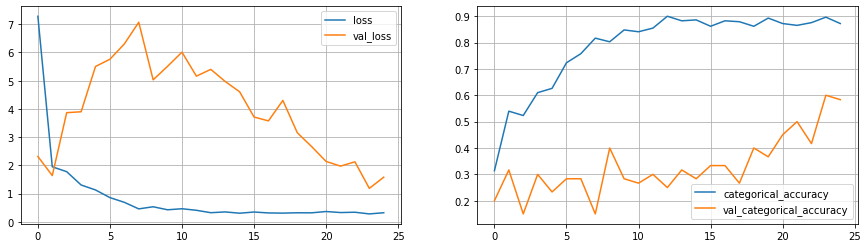

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_2 = model_architecture(25, 40, 120)
model_2.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_2.execute()

Model-2 output summary (num_epoch=25, batch_size=40) Training accuracy: 87.54 Validation accuracy: 50.00 Validation loss: 2.8498

#### Type Markdown and LaTeX: 𝛼2
#### Model-3 input summary (Conv3d architecture): (Hyperparameter tuning with reduced batch size of 30)
input image size(120x120) epochs: 25 batch size: 30

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)  

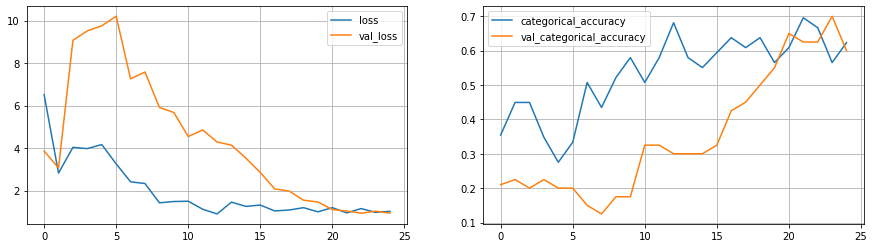

In [11]:
# Define model architecture with num_epoch, batch_size, input image size
model_3 = model_architecture(25, 30, 120)
model_3.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_3.execute()

Model-3 output summary (batch size: 30, epochs:25) Training accuracy: 61.60 Validation accuracy: 82.50 Validation loss : 0.61603

#### Model-4 input summary (Conv3d architecture): With image size 150x150
Input image size(150x150) epochs: 25 batch size: 40 In this attempt, try to change the image width/height size and see how it performed compared to previous model in 25 nb of epocs

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_10 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_11 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 75, 75, 16)  

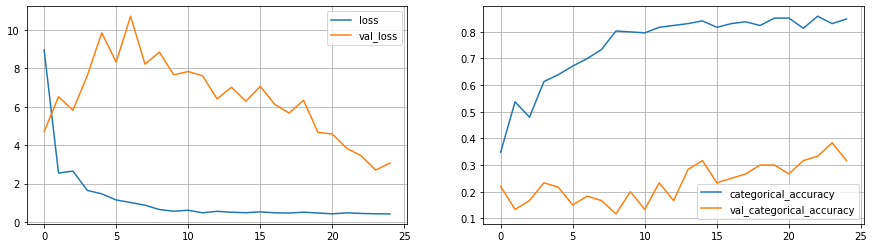

In [21]:
# Define model architecture with num_epoch, batch_size, input image size
model_4 = model_architecture(25, 40, 150)
model_4.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_4.execute()

Model-4 output summary Training accuracy: 39.59 Validation accuracy: 84.43 Validation loss: 1.67

Train model with batch size: 50, epochs: 25 and compare the model with 120x120 & 150x150 image size

#### Model-5 input summary (Conv3d architecture): Hyper parameter tuning, increased batch size: 50
input image size(120x120) epochs: 25 batch size: 50 In this attempt, try to change the image width/height size and see how it performed compared to previous model in 25 nb of epocs

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)  

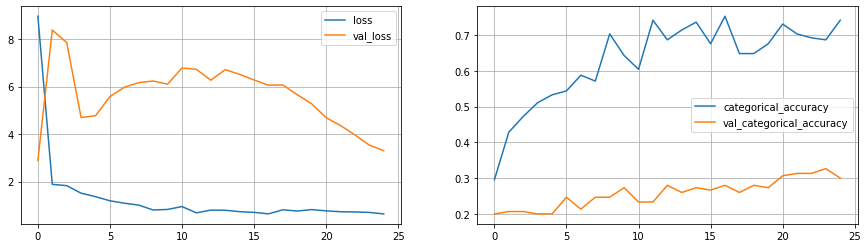

In [12]:
# Define model architecture with num_epoch, batch_size, input image size
model_5 = model_architecture(25, 50, 120)
model_5.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_5.execute()

Model-5 output summary Training accuracy: 30.47 Validation accuracy: 27.33 Validation loss: 1.6477 We can observe that batch size: 50 does not perform better compared with batch size: 40

#### Model-6 input summary (Conv3d architecture): With image size (150x150)
input image size(150x150) epochs: 25 batch size: 50 With higher number of batches, we can notice OOM error. With further resource optimization and increased processing power model can be trained and behavior can be observed.

In [13]:
# Define model architecture with num_epoch, batch_size, input image size
model_6 = model_architecture(25, 50, 150)
model_6.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_6.execute()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_16 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 75, 75, 16)  

2023-02-05 12:11:55.880259: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB (rounded to 2160000000)requested by op gradient_tape/sequential_3/max_pooling3d_12/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-05 12:11:55.880384: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-02-05 12:11:55.880421: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 285, Chunks in use: 284. 71.2KiB allocated for chunks. 71.0KiB in use in bin. 21.5KiB client-requested in use in bin.
2023-02-05 12:11:55.880447: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 45, Chunks in use: 44. 22.8KiB allocated for chunks. 22.0KiB in use in bin. 22.0KiB

ResourceExhaustedError:  OOM when allocating tensor with shape[50,16,30,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_3/max_pooling3d_12/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_17241]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_3/max_pooling3d_12/MaxPool3D/MaxPool3DGrad:
In[0] sequential_3/batch_normalization_16/FusedBatchNormV3 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:589)	
In[1] sequential_3/max_pooling3d_12/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_3/conv3d_17/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_434/454466772.py", line 5, in <module>
>>>     model_6.execute()
>>> 
>>>   File "/tmp/ipykernel_434/1388290089.py", line 293, in execute
>>>     history = self.model_arch.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

Train model with 50 epochs and compare 120x120, 150x150 image size

#### Model-7 input summary (Conv3d architecture): Hyper parameter tuning (With epochs 50)
input image size(120x120) epochs: 50 batch size: 40

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_20 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_21 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_21 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)  

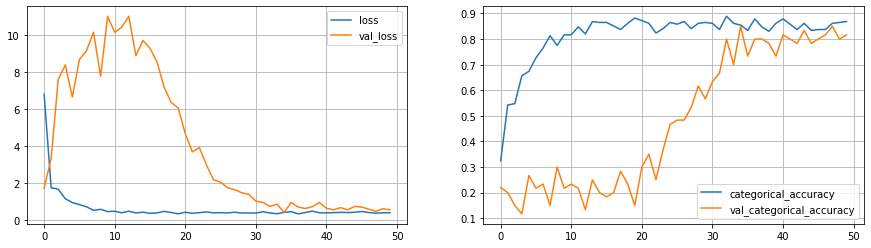

In [14]:
# Define model architecture with num_epoch, batch_size, input image size
model_7 = model_architecture(50, 40, 120)
model_7.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_7.execute()

Model-7 output summary Training accuracy: 38.37 Validation accuracy: 87.54 Validation loss: 0.52305 We can observe that training the model with more number of epochs improve the result overall and validation loss comes down to 0.52305

#### Model-8 input summary (Conv3d architecture): With image size (150x150)
input image size(150x150) epochs: 50 batch size: 40

2023-02-07 11:37:50.502022: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-07 11:37:50.502086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 150, 150, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 150, 150, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 75, 75, 16)   0

2023-02-07 11:38:01.534728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 8.7693 - categorical_accuracy: 0.3137Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.96303, saving model to model_init_2023-02-0711_37_23.975409/model-00001-8.76931-0.31373-1.96303-0.19000.h5
17/17 [==============================] - 182s 11s/step - loss: 8.7693 - categorical_accuracy: 0.3137 - val_loss: 1.9630 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 2.3625 - categorical_accuracy: 0.4348
Epoch 00002: val_loss did not improve from 1.96303
17/17 [==============================] - 107s 6s/step - loss: 2.3625 - categorical_accuracy: 0.4348 - val_loss: 2.5645 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6731 - categorical_accuracy: 0.7612
Epoch 00009: val_loss did not improve from 1.96303

Epoch 00009: ReduceLROnPlateau reducin

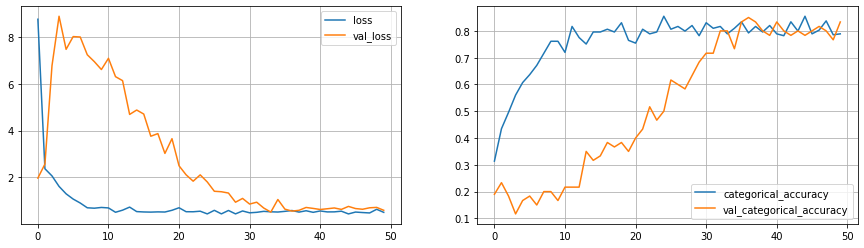

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_8 = model_architecture(50, 40, 150)
model_8.define_conv3d_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_8.execute()

#### Model-9 (Image-size 120x120)
num_epoch: 25 batch_size: 40 image_size: 120x120 Model training with less number of epochs

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)  

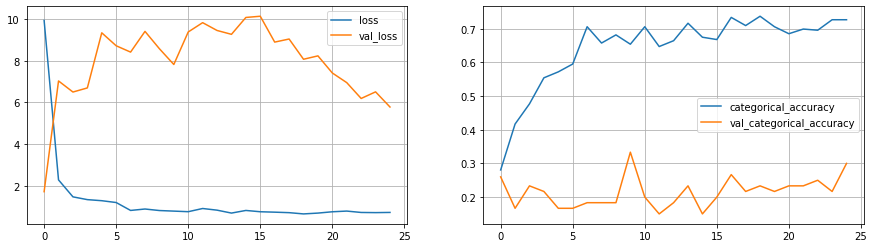

In [11]:
# Define model architecture with num_epoch, batch_size, input image size
model_9 = model_architecture(25, 40, 120)
model_9.define_conv3d_architecture_2();
print('\n\n=========== Training the model ===========\n\n')
model_9.execute()

Model-9 output summary Training accuracy: 31.22 Validation accuracy: 22.00 Validation loss: 2.7215

Trying different architecture(3) -(Conv3d architecture): With image size (120x120)



#### Model-10 Input summary (Image-size 120x120)
num_epoch: 25 batch_size: 40 image_size: 120x120

Model training with less number of epochs

2023-02-11 11:49:14.769145: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-11 11:49:14.769216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 32)   128       
 hNormalization)                                                 
                                                        

2023-02-11 11:49:25.605408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 6.3383 - categorical_accuracy: 0.3424Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.63899, saving model to model_init_2023-02-1111_48_46.518324/model-00001-6.33833-0.34238-1.63899-0.21000.h5
17/17 [==============================] - 162s 10s/step - loss: 6.3383 - categorical_accuracy: 0.3424 - val_loss: 1.6390 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.4821 - categorical_accuracy: 0.5678
Epoch 00002: val_loss did not improve from 1.63899
17/17 [==============================] - 93s 6s/step - loss: 1.4821 - categorical_accuracy: 0.5678 - val_loss: 2.1136 - val_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.2467 - categorical_accuracy: 0.5995
Epoch 00003: val_loss did not improve from 1.63899

Epoch 00003: ReduceLROnPlateau reducing

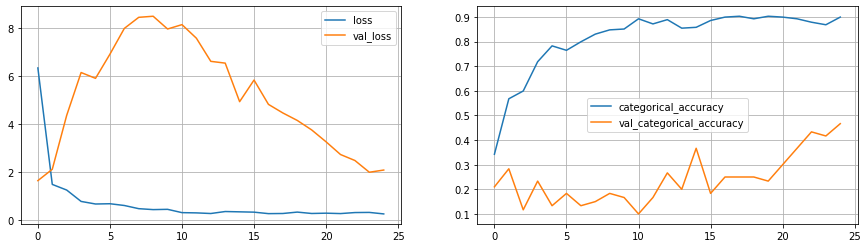

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_10 = model_architecture(25, 40, 120)
model_10.define_conv3d_architecture_3();
print('\n\n=========== Training the model ===========\n\n')
model_10.execute()

Model-10 output summary Training accuracy: 89.97 Validation accuracy: 46.67 Validation loss: 0.2516

2023-02-07 15:39:05.549099: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-07 15:39:05.549181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

2023-02-07 15:39:17.129991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 3.2030 - categorical_accuracy: 0.3032Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.59791, saving model to model_init_2023-02-0715_38_36.761318/model-00001-3.20300-0.30317-1.59791-0.17000.h5
17/17 [==============================] - 177s 11s/step - loss: 3.2030 - categorical_accuracy: 0.3032 - val_loss: 1.5979 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.9673 - categorical_accuracy: 0.4246
Epoch 00002: val_loss improved from 1.59791 to 1.55862, saving model to model_init_2023-02-0715_38_36.761318/model-00002-1.96729-0.42455-1.55862-0.28333.h5
17/17 [==============================] - 109s 7s/step - loss: 1.9673 - categorical_accuracy: 0.4246 - val_loss: 1.5586 - val_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.4432 - categorical_ac

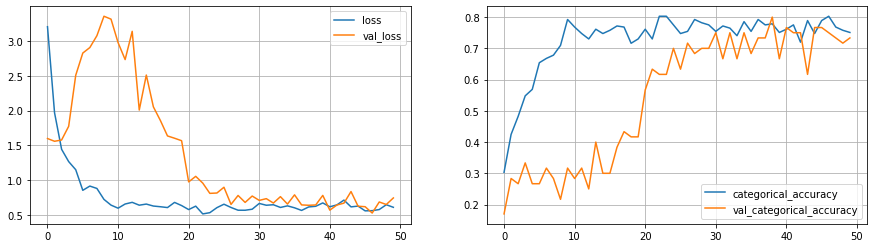

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_11 = model_architecture(50, 40, 120)
model_11.define_conv3d_architecture_1_sgd_variant();
print('\n\n=========== Training the model ===========\n\n')
model_11.execute()

Model-11 output summary Training accuracy: 66.30 Validation accuracy: 75.78 Validation loss: 0.53

#### Model 12 : Conv2D & LSTM architecture
batch-size:40 epochs: 50 Image-size: 120x120

2023-02-08 10:48:50.886999: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-08 10:48:50.887080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 16)   6

2023-02-08 10:49:03.846505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4916 - categorical_accuracy: 0.3379Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.66352, saving model to model_init_2023-02-0810_47_32.090483/model-00001-1.49158-0.33786-1.66352-0.19000.h5
17/17 [==============================] - 159s 10s/step - loss: 1.4916 - categorical_accuracy: 0.3379 - val_loss: 1.6635 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.1550 - categorical_accuracy: 0.5448
Epoch 00002: val_loss did not improve from 1.66352
17/17 [==============================] - 95s 6s/step - loss: 1.1550 - categorical_accuracy: 0.5448 - val_loss: 1.7642 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.0800 - categorical_accuracy: 0.5531
Epoch 00003: val_loss did not improve from 1.66352

Epoch 00003: ReduceLROnPlateau reducing

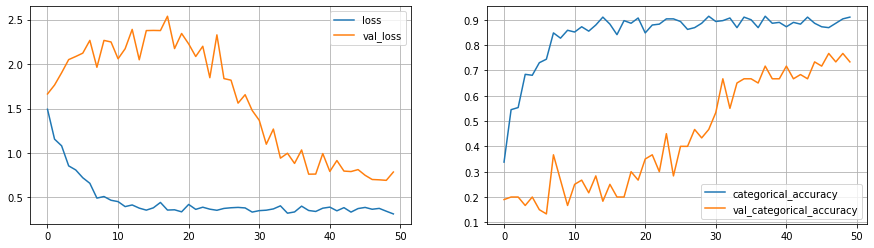

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_12 = model_architecture(50, 40, 120)
model_12.define_rnn_lstm_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_12.execute()

Model-12 output summary Training accuracy : 88.93 Validation accuracy: 85.00 Validation loss : 0.52296

#### Model 13: Conv2D & GRU architecture (Image size: 120x120, epochs: 50)
batch-size:40 epochs: 50 Image-size: 120x120

2023-02-08 12:32:34.256242: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-08 12:32:34.256331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 16)   6

2023-02-08 12:32:47.074940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.4193Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.90076, saving model to model_init_2023-02-0812_31_47.107767/model-00001-1.43466-0.41931-1.90076-0.19000.h5
17/17 [==============================] - 161s 10s/step - loss: 1.4347 - categorical_accuracy: 0.4193 - val_loss: 1.9008 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.9544 - categorical_accuracy: 0.5908
Epoch 00008: val_loss did not improve from 1.90076
17/17 [==============================] - 79s 5s/step - loss: 0.3000 - categorical_accuracy: 0.9100 - val_loss: 2.4913 - val_categorical_accuracy: 0.3667 - lr: 1.2500e-04
Epoch 9/50
17/17 [==============================] - ETA: 0s - loss: 0.2477 - categorical_accuracy: 0.9308
Epoch 00009: val_loss did not improve from 1.90076

Epoch 00009: ReduceLROnPlateau redu

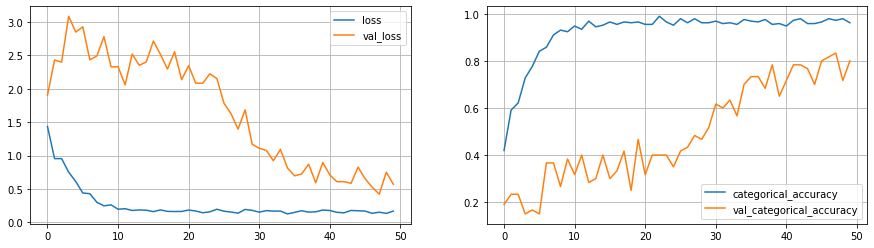

In [10]:
# Define model architecture with num_epoch, batch_size, input image size
model_13 = model_architecture(50, 40, 120)
model_13.define_rnn_gru_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_13.execute()

Model-13 output summary Training accuracy : 95.85 Validation accuracy: 80.00 Validation loss : 0.5104

GRU is the best model so far

#### Data Augmentation: Training the best model (model 13) with data augmentation (affine strategy) to see the output

In [10]:
x = 30 # No. of frames images
def generator_with_data_augmentation(source_path, folder_list, batch_size, width=120, height=120):
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Let us resize all the images 
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1, y0:y1, :]
                    
                    resized_image = resize(cropped,(width, height))
                    resized_image = resized_image/255
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches        
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x, width, z, 3))
            batch_labels = np.zeros((batch_size,5))  
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    resized_image = resize(cropped,(width, height))
                    resized_image = resized_image/255
                                        
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [11]:
class model_architecture_data_augmentation:
    # initialize default parameter
    num_epochs = 25
    batch_size = 40
    image_width_height = 120
    
    #defining constructor  
    def __init__(self, num_epochs = 15, batch_size = 40, image_width_height = 120):  
        self.num_epochs = num_epochs  
        self.batch_size = batch_size 
        self.image_width_height = image_width_height
        
    def define_conv3d_architecture_1(self):
        model_arch_1 = Sequential()       
        model_arch_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(Activation('relu'))

        model_arch_1.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

        # Flatten layer 
        model_arch_1.add(Flatten())
        model_arch_1.add(Dense(1000, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        model_arch_1.add(Dense(500, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        #Softmax layer
        model_arch_1.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
        model_arch_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_1.summary())

        self.model_arch = model_arch_1
       
    def cal_validation_steps_per_epoch(self):
        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1

        return steps_per_epoch, validation_steps

    def plot(self, history):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].grid()
        axes[0].legend(['loss','val_loss'])
        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].grid()
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    def execute(self):
        # Now that you have defined the model in define_conv3d_architecture_1, the next step is to `compile` the model. 
        # When you print the `summary` of the model, you'll see the total number of parameters you have to train.
        train_generator = generator_with_data_augmentation(train_path, train_doc, self.batch_size, self.image_width_height, self.image_width_height)
        val_generator = generator_with_data_augmentation(val_path, val_doc, self.batch_size, self.image_width_height, self.image_width_height)

        #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
        steps_per_epoch, validation_steps = self.cal_validation_steps_per_epoch()

        history = self.model_arch.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose=1, 
                        callbacks = callbacks_list, validation_data = val_generator, 
                        validation_steps = validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.plot(history)
        
        return history

#### Model 14: GPU architecture (Image size: 120x120, epochs: 50)
batch-size:40 epochs: 50 Image-size: 120x120

2023-02-08 15:53:26.562071: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-08 15:53:26.562153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 16)   6

2023-02-08 15:53:38.195776: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4399 - categorical_accuracy: 0.4193Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.53689, saving model to model_init_2023-02-0815_51_12.260121/model-00001-1.43995-0.41931-1.53689-0.26000.h5
17/17 [==============================] - 165s 10s/step - loss: 1.4399 - categorical_accuracy: 0.4193 - val_loss: 1.5369 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.8844 - categorical_accuracy: 0.6419
Epoch 00002: val_loss did not improve from 1.53689
17/17 [==============================] - 98s 6s/step - loss: 0.8844 - categorical_accuracy: 0.6419 - val_loss: 2.0155 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.8619 - categorical_accuracy: 0.6676
Epoch 00003: val_loss did not improve from 1.53689

Epoch 00003: ReduceLROnPlateau reducing

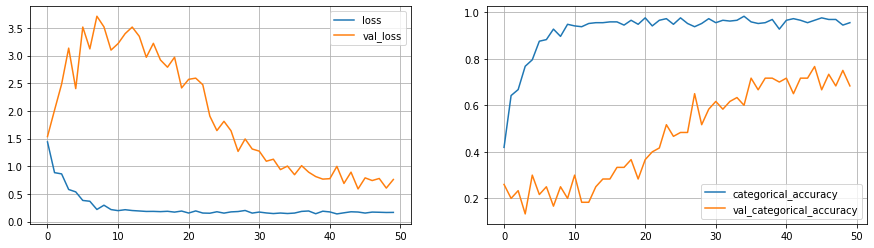

In [12]:
# Define model architecture with num_epoch, batch_size, input image size
model_14 = model_architecture(50, 40, 120)
model_14.define_rnn_gru_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_14.execute()